# Audio processing notes

Interactive development of the functions needed for audio processing.

In [57]:
df[['url', 'file']]

,url,file
id,,
573469,//xeno-canto.org/573469,https://xeno-canto.org/573469/download
528241,//xeno-canto.org/528241,https://xeno-canto.org/528241/download
501433,//xeno-canto.org/501433,https://xeno-canto.org/501433/download
477212,//xeno-canto.org/477212,https://xeno-canto.org/477212/download
942770,//xeno-canto.org/942770,https://xeno-canto.org/942770/download
...,...,...
254319,//xeno-canto.org/254319,https://xeno-canto.org/254319/download
177143,//xeno-canto.org/177143,https://xeno-canto.org/177143/download
155350,//xeno-canto.org/155350,https://xeno-canto.org/155350/download


In [53]:
list(Path('../audio/data/raw/').resolve().glob("*.mp3"))[:5]

[PosixPath('/Users/dcf/Repos/danielcfurr/phoebe/audio/data/raw/309932.mp3'),
 PosixPath('/Users/dcf/Repos/danielcfurr/phoebe/audio/data/raw/129079.mp3'),
 PosixPath('/Users/dcf/Repos/danielcfurr/phoebe/audio/data/raw/737551.mp3'),
 PosixPath('/Users/dcf/Repos/danielcfurr/phoebe/audio/data/raw/702313.mp3'),
 PosixPath('/Users/dcf/Repos/danielcfurr/phoebe/audio/data/raw/800862.mp3')]

In [49]:
p = Path('../audio/data/raw/')
p.glob?

Signature: p.glob(pattern, *, case_sensitive=None)
Docstring:
Iterate over this subtree and yield all existing files (of any
kind, including directories) matching the given relative pattern.
File:      ~/miniconda3/lib/python3.12/pathlib.py
Type:      method

In [25]:
import requests
import json
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import Audio
from pydub import AudioSegment

from birdnetlib import Recording
from birdnetlib.analyzer import Analyzer
from geopy.distance import distance
from datetime import datetime

from dotenv import load_dotenv
import os
load_dotenv() 
API_KEY = os.getenv("XENOCANTO_API_KEY")

In [31]:
df = pd.read_csv("../audio/data/manifest.csv").set_index("id")

df.columns

df[['gen', 'sp', 'length']]

,gen,sp,length
id,,,
573469,Sayornis,nigricans,0:13
528241,Sayornis,nigricans,0:08
501433,Sayornis,nigricans,0:42
477212,Sayornis,nigricans,0:00
942770,Sayornis,nigricans,0:35
...,...,...,...
254319,Setophaga,coronata,0:43
177143,Setophaga,coronata,0:08
155350,Setophaga,coronata,0:13


<Axes: ylabel='Frequency'>

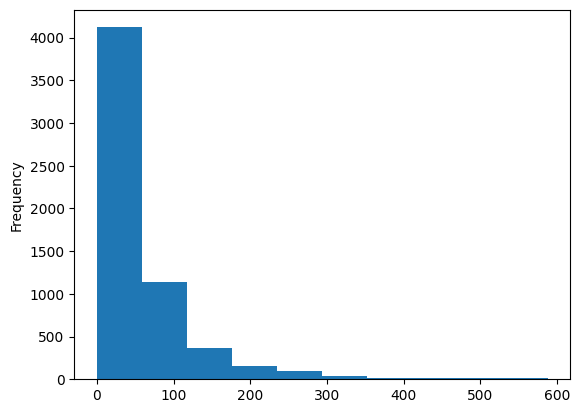

In [41]:
def time_to_seconds(time_str: str):
    x = time_str.split(':')
    
    if len(x) == 2:
        m, s = x
        h = 0
    elif len(x) == 3:
        h, m, s = x
    else:
        raise ValueError(f"`time_str` should be mm:ss or hh:mm:ss but instead received {time}.")
                         
    return int(h)*60*60 + int(m)*60 + int(s)


x = df['length'].apply(time_to_seconds)
x[x < 600].plot(kind='hist')

In [44]:
df['lat'].notna()

id
573469     True
528241     True
501433     True
477212     True
942770     True
          ...  
254319     True
177143    False
155350     True
130251     True
122173     True
Name: lat, Length: 6045, dtype: bool

In [46]:
df['lon'].max()

175.4737

In [24]:
def query_xenocanto(query_params, key, per_page=100, page=1):
    base_url = "https://xeno-canto.org/api/3/recordings"
    query_string = ' '.join([f'{key}:"{item}"' for key, item in query_params])
    return requests.get(base_url, params={"query": query_string, "key": key, "per_page": per_page, "page": page})


def manifest_xenocanto(scientific_name, key):
    query_params = [("sp", scientific_name)]

    print(scientific_name, "first request")
    first_response = query_xenocanto(query_params, key=key, page=1)
    first_data = first_response.json()
    pages = first_data["numPages"]
    
    recording_list = [first_data["recordings"]]
    for p in range(2, pages + 1):
        print(scientific_name, "page", p, "of", pages)
        response = query_xenocanto(query_params, key=key, page=p)
        additional_recordings = response.json()['recordings']
        recording_list.append(additional_recordings)
    
    df = pd.concat(
        [pd.DataFrame(data) for data in recording_list],
        axis=0
    )

    df = df.set_index("id")
    
    return df


recordings = manifest_xenocanto("Sayornis nigricans", API_KEY)

recordings

Sayornis nigricans first request
Sayornis nigricans page 2 of 3
Sayornis nigricans page 3 of 3


,gen,sp,ssp,grp,en,rec,cnt,loc,lat,lon,...,also,rmk,animal-seen,playback-used,temp,regnr,auto,dvc,mic,smp
id,,,,,,,,,,,,,,,,,,,,,
573469,Sayornis,nigricans,,birds,Black Phoebe,Ron Overholtz,United States,"Owen's Gorge, Mono County, California",37.5876,-118.6882,...,[],Atr 6550 mic\r\nTascam Dr-05\r\nAudacity,yes,no,,,no,,,44100
528241,Sayornis,nigricans,,birds,Black Phoebe,Thomas Magarian,United States,"William Finley NWR Headquarters, Benton County...",44.408,-123.3364,...,[],,yes,no,,,no,,,44100
501433,Sayornis,nigricans,,birds,Black Phoebe,Lauren Harter,United States,"Ahakhav Tribal Preserve, Parker, Arizona",34.1287,-114.3332,...,[],"Before recording, bird was giving a series of ...",yes,no,,,no,,,48000
477212,Sayornis,nigricans,,birds,Black Phoebe,Thomas Magarian,United States,"William Finley NWR Headquarters, Benton County...",44.408,-123.3364,...,[],Recording amplified. High pass filter.,yes,no,,,no,,,44100
942770,Sayornis,nigricans,,birds,Black Phoebe,Carlos Delgado JUMABITA,Colombia,"Quebrada El Viao, Cocorná, Antioquia",6.0627,-75.2212,...,[],,yes,no,,,no,,,48000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4085,Sayornis,nigricans,,birds,Black Phoebe,Sebastian K. Herzog,Bolivia,"Kms 9 to 12 on road Puente Azero - Monteagudo,...",-19.6501,-64.0501,...,[],"Three birds at a creek, often switching perc...",unknown,unknown,,,no,,,44100
921133,Sayornis,nigricans,,birds,Black Phoebe,Michael Hurben,United States,"Martinez, Contra Costa County, California",38.0231,-122.1377,...,[],,yes,no,,,no,Tascam DR-05X,,44100
302447,Sayornis,nigricans,,birds,Black Phoebe,Alfonso Auerbach,Honduras,"Rancho Bella Vista, Lago de Yojoa, Santa Cruz ...",14.8498,-87.9591,...,"[Pitangus sulphuratus, Quiscalus mexicanus]",,yes,no,,,no,,,44100


In [23]:
def manifest_xenocanto(scientific_name, key):
    query_params = [("sp", scientific_name)]

    first_response = query_xenocanto(query_params, key=key, page=1)
    first_data = first_response.json()
    
    recording_list = [first_data["recordings"]]
    for p in range(2, first_data["numPages"] + 1):
        response = query_xenocanto(query_params, key=key, page=p)
        additional_recordings = response.json()['recordings']
        recording_list.append(additional_recordings)
    
    df = pd.concat(
        [pd.DataFrame(data) for data in recording_list],
        axis=0
    )

    df = df.set_index("id")
    
    return df

,id,gen,sp,ssp,grp,en,rec,cnt,loc,lat,...,also,rmk,animal-seen,playback-used,temp,regnr,auto,dvc,mic,smp
0,573469,Sayornis,nigricans,,birds,Black Phoebe,Ron Overholtz,United States,"Owen's Gorge, Mono County, California",37.5876,...,[],Atr 6550 mic\r\nTascam Dr-05\r\nAudacity,yes,no,,,no,,,44100
1,528241,Sayornis,nigricans,,birds,Black Phoebe,Thomas Magarian,United States,"William Finley NWR Headquarters, Benton County...",44.408,...,[],,yes,no,,,no,,,44100
2,501433,Sayornis,nigricans,,birds,Black Phoebe,Lauren Harter,United States,"Ahakhav Tribal Preserve, Parker, Arizona",34.1287,...,[],"Before recording, bird was giving a series of ...",yes,no,,,no,,,48000
3,477212,Sayornis,nigricans,,birds,Black Phoebe,Thomas Magarian,United States,"William Finley NWR Headquarters, Benton County...",44.408,...,[],Recording amplified. High pass filter.,yes,no,,,no,,,44100
4,942770,Sayornis,nigricans,,birds,Black Phoebe,Carlos Delgado JUMABITA,Colombia,"Quebrada El Viao, Cocorná, Antioquia",6.0627,...,[],,yes,no,,,no,,,48000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,4085,Sayornis,nigricans,,birds,Black Phoebe,Sebastian K. Herzog,Bolivia,"Kms 9 to 12 on road Puente Azero - Monteagudo,...",-19.6501,...,[],"Three birds at a creek, often switching perc...",unknown,unknown,,,no,,,44100
99,921133,Sayornis,nigricans,,birds,Black Phoebe,Michael Hurben,United States,"Martinez, Contra Costa County, California",38.0231,...,[],,yes,no,,,no,Tascam DR-05X,,44100
0,302447,Sayornis,nigricans,,birds,Black Phoebe,Alfonso Auerbach,Honduras,"Rancho Bella Vista, Lago de Yojoa, Santa Cruz ...",14.8498,...,"[Pitangus sulphuratus, Quiscalus mexicanus]",,yes,no,,,no,,,44100
1,254183,Sayornis,nigricans,,birds,Black Phoebe,Joe Klaiber,Venezuela,"La Mucuy, Merida",8.6071,...,[],,unknown,unknown,,,no,,,44100


In [21]:
first_data["numRecordings"]

'203'

In [ ]:
response = query_xenocanto(query_params, API_KEY)

In [13]:
print(str(response.json())[:500])

{'numRecordings': '203', 'numSpecies': '1', 'page': 1, 'numPages': 3, 'recordings': [{'id': '573469', 'gen': 'Sayornis', 'sp': 'nigricans', 'ssp': '', 'grp': 'birds', 'en': 'Black Phoebe', 'rec': 'Ron Overholtz', 'cnt': 'United States', 'loc': "Owen's Gorge, Mono County, California", 'lat': '37.5876', 'lon': '-118.6882', 'alt': '2000', 'type': 'call', 'sex': '', 'stage': 'adult', 'method': 'field recording', 'url': '//xeno-canto.org/573469', 'file': 'https://xeno-canto.org/573469/download', 'fil


In [14]:
response_2 = query_xenocanto(query_params, API_KEY, page=2)
print(str(response_2.json())[:500])

{'numRecordings': '203', 'numSpecies': '1', 'page': 2, 'numPages': 3, 'recordings': [{'id': '492147', 'gen': 'Sayornis', 'sp': 'nigricans', 'ssp': '', 'grp': 'birds', 'en': 'Black Phoebe', 'rec': 'Phoenix Birder', 'cnt': 'United States', 'loc': 'Young, Gila County, Arizona', 'lat': '33.818', 'lon': '-110.9316', 'alt': '2000', 'type': 'call', 'sex': '', 'stage': '', 'method': 'field recording', 'url': '//xeno-canto.org/492147', 'file': 'https://xeno-canto.org/492147/download', 'file-name': 'XC492


Make a manifest of audio data to download and prepare. Call separately for each species.

In [2]:
def get_manifest_for_target(target: str, lat: float, lng: float, n_recordings: int) -> pd.DataFrame:
    """Get a dataframe of audio files for target bird"""
    base_url = "https://xeno-canto.org/api/2/recordings"
    
    # Make the request
    response = requests.get(base_url, params={"query": target})
    
    # Check for success
    if response.status_code == 200:
        data = response.json()
    else:
        print(f"Request failed with status code {response.status_code}")
    
    df = pd.DataFrame(data['recordings']).set_index('id')
    
    df['km'] = df.apply(lambda row: distance((lat, lng), (row['lat'], row['lng'])).km, axis=1)
    
    penalty = df['q'].map({'A': 0, 'B': 500, 'C': 1000}).fillna(2000)
    df['penalized_km'] = df['km'] + penalty

    df['local_raw'] = 'audio/raw/' + df.index + '.mp3'
    df['local_processed'] = 'audio/processed/' + df.index + '.mp3'
    
    return df.sort_values('penalized_km').head(n_recordings)


manifest = get_manifest_for_target(target="Black Phoebe", lat=37, lng=-122, n_recordings=5)

manifest

,gen,sp,ssp,group,en,rec,cnt,loc,lat,lng,...,temp,regnr,auto,dvc,mic,smp,km,penalized_km,local_raw,local_processed
id,,,,,,,,,,,,,,,,,,,,,
842469,Sayornis,nigricans,,birds,Black Phoebe,Matthew L. Brady,United States,"Southeast Farallon Island, San Francisco Count...",37.6989,-123.0029,...,,,no,Sound Devices MixPre-3 II,Sennheiser ME67,48000,117.950440,117.950440,audio/raw/842469.mp3,audio/processed/842469.mp3
357024,Sayornis,nigricans,,birds,Black Phoebe,Jim Holmes,United States,"Partrick, Napa County, California",38.3146,-122.3725,...,,,no,,,48000,149.563516,149.563516,audio/raw/357024.mp3,audio/processed/357024.mp3
351287,Sayornis,nigricans,,birds,Black Phoebe,Antonio Xeira,United States,"Merced River, Mariposa County, California",37.5964,-120.0039,...,,,no,,,44100,188.947423,188.947423,audio/raw/351287.mp3,audio/processed/351287.mp3
875440,Sayornis,nigricans,,birds,Black Phoebe,Ed Pandolfino,United States,"Folsom Lake State Park Peninsula, El Dorado Co...",38.7438,-121.1089,...,,,no,Nagra Seven,Sennheiser MKH20,48000,208.825021,208.825021,audio/raw/875440.mp3,audio/processed/875440.mp3
898666,Sayornis,nigricans,,birds,Black Phoebe,Ed Pandolfino,United States,"Sand Creek Rd, Colusa County, California",38.9978,-122.2155,...,,,no,Nagra Seven,Sennheiser MKH20,48000,222.554920,222.554920,audio/raw/898666.mp3,audio/processed/898666.mp3


Use the manifest row by row to download audio files.

In [3]:
def download_if_absent(url: str, filepath: str) -> bool:
    """Download file if absent, returning True if successful or file already present"""
    path = Path(filepath)
    if path.exists():
        return True

    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Failed download to {path}. Status code: {response.status_code}")
        return False

    path.parent.mkdir(parents=True, exist_ok=True)
    with open(filepath, 'wb') as f:
        f.write(response.content)
               
    return True


record_id = manifest.index[0]

download_if_absent(manifest.loc[record_id, 'file'], manifest.loc[record_id, 'local_raw'])

True

Run birdnet identification model on each audio file.

Find the audio segment the best excludes other bird species.

In [4]:
analyzer = Analyzer()

def analyze(analyzer: Analyzer, filepath: str, lat: float, lng: float, date: str) -> Recording:
    """Run the birdnet model against an audio file"""
    recording = Recording(
        analyzer, filepath,
        lat=lat, lon=lng, date=pd.to_datetime(date),
        return_all_detections=True,
    )

    recording.analyze()

    return recording


recording = analyze(
    analyzer,
    filepath=manifest.loc[record_id, 'local_raw'],
    lat=manifest.loc[record_id, 'lat'],
    lng=manifest.loc[record_id, 'lng'],
    date=manifest.loc[record_id, 'date']
)

Labels loaded.
load model True
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.
read_audio_data


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


read_audio_data: complete, read  14 chunks.
analyze_recording 842469.mp3
recording has lon/lat
set_predicted_species_list_from_position
return_predicted_species_list
41
190 species loaded.


In [5]:
def search_windows(rec: Recording, target: str, segments_per_window) -> tuple:
    """Return the start time, end time, and score for the best window in a recording"""
    detections = pd.DataFrame(rec.detections).set_index(['start_time', 'end_time'])
    segment_seconds = detections.index[0][1]

    segment_scores = []
    for idx in detections.index.drop_duplicates():
        on_target = pd.Series(detections.loc[idx, 'common_name'] == target)
        valence = on_target.map({True: 1, False: -1})
        segment_scores.append(np.sum(valence * detections.loc[idx, 'confidence']))

    window_scores = [np.mean(segment_scores[i:(i + segments_per_window)]) for i in
                     range(len(segment_scores) - segments_per_window)]

    best = np.argmax(window_scores)
    start = best * segment_seconds
    end = (best + segments_per_window) * segment_seconds

    return start, end, window_scores[best]

start, end, score = search_windows(recording, 'Black Phoebe', 4)

print(start, end, score)

6.0 18.0 0.9909851998090744


Clip the audio file and store.

In [6]:
def process_mp3(raw_path: str, start_sec: float, end_sec: float, output_path: str) -> None:
    """Clip an audio file saving a new copy"""
    audio = AudioSegment.from_mp3(raw_path)
    clipped = audio[start * 1000:end * 1000]

    path = Path(output_path)
    path.parent.mkdir(parents=True, exist_ok=True)

    clipped.export(path, format="mp3")

    return None


process_mp3(manifest.loc[record_id, 'local_raw'], start, end, manifest.loc[record_id, 'local_processed'])

# Audio(filename=manifest.loc[record_id, 'local_processed'])

In [8]:
recording = analyze(
    analyzer,
    '../audio/data/raw/537272.mp3',
    lat=None,
    lng=manifest.loc[record_id, 'lng'],
    date=manifest.loc[record_id, 'date']
)

read_audio_data
read_audio_data: complete, read  5 chunks.
analyze_recording 537272.mp3


In [ ]:
search_windows(recording)

In [9]:
recording.detections

[{'common_name': 'Orange-crowned Warbler',
  'scientific_name': 'Leiothlypis celata',
  'start_time': 0.0,
  'end_time': 3.0,
  'confidence': 0.9955275654792786,
  'label': 'Leiothlypis celata_Orange-crowned Warbler',
  'is_predicted_for_location_and_date': True},
 {'common_name': 'Evergreen-forest Warbler',
  'scientific_name': 'Bradypterus lopezi',
  'start_time': 3.0,
  'end_time': 6.0,
  'confidence': 0.11385046690702438,
  'label': 'Bradypterus lopezi_Evergreen-forest Warbler',
  'is_predicted_for_location_and_date': False},
 {'common_name': 'Sulphur-crested Cockatoo',
  'scientific_name': 'Cacatua galerita',
  'start_time': 9.0,
  'end_time': 12.0,
  'confidence': 0.27636557817459106,
  'label': 'Cacatua galerita_Sulphur-crested Cockatoo',
  'is_predicted_for_location_and_date': False},
 {'common_name': 'Eurasian Jay',
  'scientific_name': 'Garrulus glandarius',
  'start_time': 9.0,
  'end_time': 12.0,
  'confidence': 0.13944979012012482,
  'label': 'Garrulus glandarius_Eurasian 